<a href="https://colab.research.google.com/github/sumitthakur24/Amazon-Fine-Food-Review/blob/master/05_Amazon_Fine_Food_Reviews_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 
print(filtered_data.shape)
filtered_data.head(3)


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
  if x<3:
    return 0
  return 1

In [5]:
actualscore=filtered_data['Score']
posneg=actualscore.map(partition)
filtered_data['Score']=posneg
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
for i in range(0,364171):
  final['Text'].values[i]=re.sub(r"http\S+","",final['Text'].values[i])
  

In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup=BeautifulSoup(final['Text'].values[i],'lxml')
  text=soup.get_text()
  final['Text'].values[i]=text


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
for i in range(0,364171):
  final['Text'].values[i]=decontracted(final['Text'].values[i])


In [0]:
#remove words with numbers python
for i in range(0,364171):
  final['Text'].values[i]=re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()


In [0]:
#remove spacial character
for i in range(0,364171):
  final['Text'].values[i]=re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:35<00:00, 2338.14it/s]


In [20]:
print(len(preprocessed_reviews))
preprocessed_reviews[1500]

364171


'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [21]:
final['cleaned_text']=preprocessed_reviews
print(final.shape)
final.head()

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [22]:
#sampling 100k data(randomly taken)
random_100k=final.sample(n=100000)
random_100k.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
376303,406898,B000KEPBBY,ALFVOKCROM3GK,Linda Sue,1,1,1,1324166400,Bob's Red Mill Veggie soup,Bob is Red Mill Veggie soup is a great soup st...,bob red mill veggie soup great soup starter us...
338968,366739,B000GAT6MM,A2E83WJYA9UCE5,Cricketais,0,1,1,1316476800,Hemp seeds,Excellent company I will definitely order from...,excellent company definitely order quick effic...
335535,363050,B001EPQN8I,A1XUJ1FXTB0XW7,"Lois Savery ""senior shopper""",1,1,1,1214179200,Food not able to find,I have been shopping for Sugar Twin for two mo...,shopping sugar twin two months used product tw...


## Time Based Splitting


In [23]:
time_sort=random_100k.sort_values('Time',axis=0,ascending=True)
time_sort.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,A twist of rumplestiskin captured on film star...,twist rumplestiskin captured film starring mic...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...
121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,965001600,End your Gopher Problems,I have just recently purchased the Woodstream ...,recently purchased woodstream corp gopher trap...


In [0]:
x_100k=time_sort["cleaned_text"]
y_100k=time_sort["Score"]

## Splitting in to Train ,Test and CV

In [0]:
#splitting in train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_100k,y_100k,test_size=0.2,random_state=0)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=0)


In [26]:
y_tr.value_counts()

1    54053
0     9947
Name: Score, dtype: int64

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,auc

In [0]:
#BOW
count_vect=CountVectorizer()

#train
count_vect.fit(x_tr)
tr_bow=count_vect.transform(x_tr)

#cv
cv_bow=count_vect.transform(x_cv)


### Grid search for optimal hyperparameter


In [29]:
tuned_parameters=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
model=GridSearchCV(LogisticRegression(), tuned_parameters, scoring='f1',cv=5)
#model.fit(x_tr,y_tr)
model.fit(tr_bow,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [30]:
model.best_score_

0.9518231016747486

In [31]:
model.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

###  Applying Logistic Regression with L1 regularization on BOW

In [32]:
# l1 on cv
lr_l1=LogisticRegression(C=1.0, penalty='l1')
lr_l1.fit(tr_bow,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Roc  curve for Train and CV

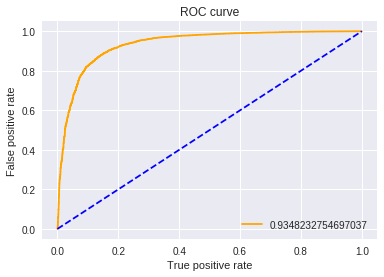

In [33]:
pred_cv=lr_l1.predict_proba(cv_bow)
fpr,tpr,threshold=roc_curve(y_cv,pred_cv[:,1])
roc_cv=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_cv, color='orange')
plt.plot([0, 1], [0, 1], 'b--')
plt.legend()
plt.show()

In [0]:
test_bow=count_vect.transform(x_test)

### Roc  curve for Train and Test

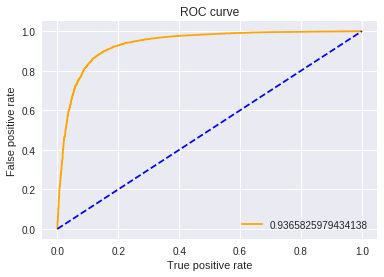

In [35]:
# l1 on test data
#lr.fit(tr_bow,y_tr)

pred_test=lr_l1.predict_proba(test_bow)
fpr,tpr,threshold=roc_curve(y_test,pred_test[:,1])
roc_test=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_test, color='orange')
plt.plot([0, 1], [0, 1], 'b--')
plt.legend()
plt.show()

In [36]:
pred=lr_l1.predict(test_bow)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3160
           1       0.94      0.97      0.95     16840

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.86      0.82      0.84     20000
weighted avg       0.92      0.92      0.92     20000



### Sparcity

In [37]:
# sparcity of matrix
w=lr_l1.coef_
print(np.count_nonzero(w))
w.shape

4808


(1, 48845)

### Applying Logistic Regression with L2 regularization on BOW

In [38]:
lr_l2=LogisticRegression(C=1.0, penalty='l2')
lr_l2.fit(tr_bow,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Roc  curve for Train and CV

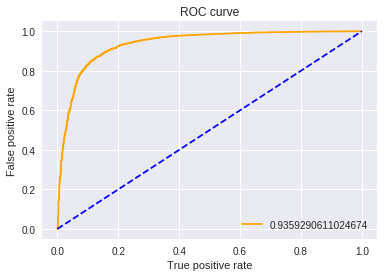

In [39]:
pred_cv=lr_l2.predict_proba(cv_bow)
fpr,tpr,threshold=roc_curve(y_cv,pred_cv[:,1])
roc_cv_l2=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_cv_l2, color='orange')
plt.plot([0, 1], [0, 1], 'b--')
plt.legend()
plt.show()

### Roc  curve for Train and Test

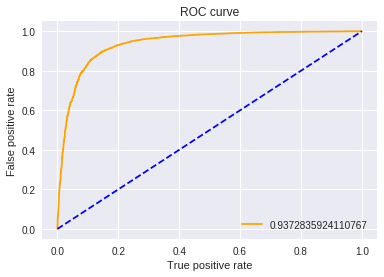

In [40]:
pred_test=lr_l2.predict_proba(test_bow)
fpr,tpr,threshold=roc_curve(y_test,pred_test[:,1])
roc_test_l2=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_test_l2, color='orange')
plt.plot([0, 1], [0, 1], 'b--')
plt.legend()
plt.show()

In [41]:
pred=lr_l2.predict(test_bow)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3160
           1       0.94      0.97      0.95     16840

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.86      0.82      0.84     20000
weighted avg       0.92      0.92      0.92     20000



### Performing pertubation test (multicollinearity check) on BOW

In [63]:
from sklearn.metrics import accuracy_score

clf=LogisticRegression(C=1.0, penalty='l2')
clf.fit(tr_bow,y_tr)
Y_pred=clf.predict(test_bow)
print("Accuracy on Test: %0.3f%%"%(accuracy_score(y_test,Y_pred)*100))
print("non zero weights:",np.count_nonzero(clf.coef_))

Accuracy on Test: 91.810%
non zero weights: 26768


In [64]:
from scipy.sparse import find
#weight before adding some random noise
weight1=find(clf.coef_[0])[2]
print(weight1[:50])

[ 2.90044486e-01  4.23871457e-02  2.82615602e-03  2.19615683e-02
  8.50177588e-02 -5.11081286e-01  6.11514198e-03 -4.55256986e-01
 -8.11185461e-03  1.12294129e-01  2.00702147e-02  2.66622324e-02
  3.68160222e-01  1.09849092e-01  9.01859290e-02  2.45105325e-06
 -1.06414598e+00  6.02052258e-03  5.81784608e-01 -2.42496872e-01
  1.28260902e-01  5.65181828e-01 -1.17733960e-01  5.00191065e-02
 -2.62551928e-03  5.22519368e-02  6.89125994e-02  2.42330857e-01
  1.79143536e-01  1.49817187e-02  4.28187572e-03  1.79400077e-01
  4.85234100e-03  6.36305388e-02 -2.55647641e-01  1.17931726e-05
  2.93021057e-01  6.87238738e-02  1.28656985e-03  7.03105989e-03
  3.59583007e-02 -1.93392147e-01  5.62461822e-02 -5.62222964e-02
 -9.68336442e-01 -9.68336442e-01 -3.22778814e-01  4.84896708e-01
  4.43543793e-02  3.37340108e-03]


In [0]:
tr_bow_t=tr_bow
#random noise
epsilon=np.random.uniform(low=-0.0001,high=0.0001, size=(find(tr_bow_t)[0].size,))
a,b,c=find(tr_bow_t)
tr_bow_t[a,b]=epsilon+tr_bow[a,b]

In [68]:
from sklearn.metrics import accuracy_score

clf_t=LogisticRegression(C=1.0, penalty='l2')
clf_t.fit(tr_bow_t,y_tr)
Y_pred=clf_t.predict(test_bow)
print("Accuracy on Test: %0.3f%%"%(accuracy_score(y_test,Y_pred)*100))
print("non zero weights:",np.count_nonzero(clf.coef_))

Accuracy on Test: 91.300%
non zero weights: 26768


In [69]:
from scipy.sparse import find
#weight after adding some random noise
weight2=find(clf.coef_[0])[2]
print(weight2[:50])

[ 2.90044486e-01  4.23871457e-02  2.82615602e-03  2.19615683e-02
  8.50177588e-02 -5.11081286e-01  6.11514198e-03 -4.55256986e-01
 -8.11185461e-03  1.12294129e-01  2.00702147e-02  2.66622324e-02
  3.68160222e-01  1.09849092e-01  9.01859290e-02  2.45105325e-06
 -1.06414598e+00  6.02052258e-03  5.81784608e-01 -2.42496872e-01
  1.28260902e-01  5.65181828e-01 -1.17733960e-01  5.00191065e-02
 -2.62551928e-03  5.22519368e-02  6.89125994e-02  2.42330857e-01
  1.79143536e-01  1.49817187e-02  4.28187572e-03  1.79400077e-01
  4.85234100e-03  6.36305388e-02 -2.55647641e-01  1.17931726e-05
  2.93021057e-01  6.87238738e-02  1.28656985e-03  7.03105989e-03
  3.59583007e-02 -1.93392147e-01  5.62461822e-02 -5.62222964e-02
 -9.68336442e-01 -9.68336442e-01 -3.22778814e-01  4.84896708e-01
  4.43543793e-02  3.37340108e-03]


In [70]:
print(weight2.size)

26768


In [0]:
weight_diff=(abs(weight1 - weight2)/weight1)*100

## [4.3] TF-IDF

In [0]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2),min_df=10)
train_tf=tf_idf_vect.fit_transform(x_tr)

cv_tf=tf_idf_vect.transform(x_cv)


In [44]:
print("train data shape:",train_tf.shape)
print("cv data shape:",cv_tf.shape)

train data shape: (64000, 37202)
cv data shape: (16000, 37202)


### Grid Search for optimal Hyperparameter

In [45]:
model_tf=GridSearchCV(LogisticRegression(),tuned_parameters, scoring='f1', cv=5)
model_tf.fit(train_tf,y_tr)
print(model_tf.best_estimator_)
model_tf.best_score_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


0.9571635097501157

###  Applying Logistic Regression with L1 regularization on TFIDF

In [46]:
lr_l1_tf=LogisticRegression(C=100, penalty='l1')
lr_l1_tf.fit(train_tf,y_tr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Roc curve for Train and CV

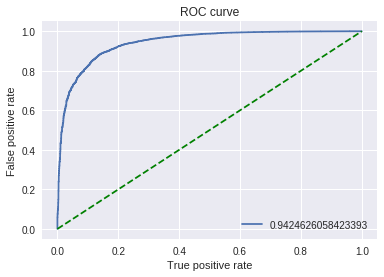

In [47]:
pred_cv_tf=lr_l1_tf.predict_proba(cv_tf)
fpr,tpr,threshold=roc_curve(y_cv,pred_cv_tf[:,1])
roc_auc_cv=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_auc_cv)
plt.plot([0, 1], [0, 1],'g--')
plt.legend()
plt.show()

In [0]:
test_tf=tf_idf_vect.transform(x_test)

## Roc curve for Train and Test

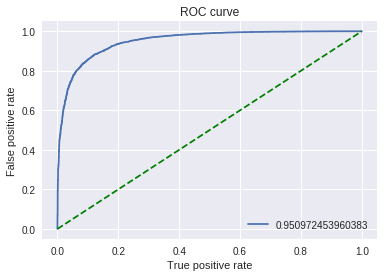

In [49]:
pred_test_tf=lr_l1_tf.predict_proba(test_tf)
fpr,tpr,threshold=roc_curve(y_test,pred_test_tf[:,1])
roc_auc_test=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_auc_test)
plt.plot([0, 1], [0, 1],'g--')
plt.legend()
plt.show()

In [50]:
pred=lr_l1_tf.predict(test_tf)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3154
           1       0.95      0.96      0.95     16846

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.92      0.92      0.92     20000



### Applying Logistic Regression with L2 regularization on TFIDF

In [51]:
lr_l2_tf=LogisticRegression(C=100, penalty='l2')
lr_l2_tf.fit(train_tf,y_tr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Roc curve on Test And Train

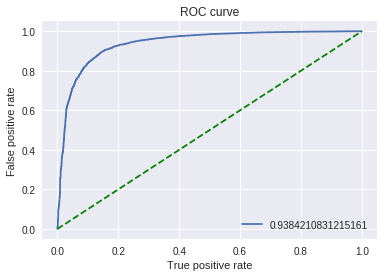

In [52]:
pred_test_tf=lr_l2_tf.predict_proba(test_tf)
fpr,tpr,threshold=roc_curve(y_test,pred_test[:,1])
roc_auc_test=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_auc_test)
plt.plot([0, 1], [0, 1],'g--')
plt.legend()
plt.show()

In [53]:
pred=lr_l2_tf.predict(test_tf)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      3154
           1       0.95      0.97      0.96     16846

   micro avg       0.93      0.93      0.93     20000
   macro avg       0.88      0.85      0.86     20000
weighted avg       0.93      0.93      0.93     20000



### Top Features

In [54]:
def top_feat(vectorizer, lr_l2_tf, n=20):
  feature_names=tf_idf_vect.get_feature_names()
  w=lr_l2_tf.coef_
  top=sorted(zip(w[0],feature_names))
  top_10 = zip(top[:n], top[:-(n + 1):-1])
  print("\t\t\tNegative\t\t\t\tPositive")
  for (coef_1, fn_1), (coef_2, fn_2) in top_10:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
  
top_feat(tf_idf_vect,lr_l2_tf)
#Code taken from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative				Positive
	-23.8186	not recommend  				26.2687	delicious      
	-23.6446	worst          				25.6843	great          
	-20.9868	disappointed   				24.1892	not disappointed
	-20.8381	not good       				22.0177	good           
	-20.2610	not worth      				21.7660	excellent      
	-19.6427	disappointing  				20.1125	best           
	-19.4546	two stars      				17.6815	perfect        
	-18.6103	terrible       				16.5379	not bad        
	-18.5281	not impressed  				16.3369	awesome        
	-17.5570	awful          				16.1310	love           
	-17.3546	not buying     				15.8974	happy          
	-15.3144	not purchase   				15.5399	tasty          
	-15.1811	no thanks      				15.4699	hooked         
	-14.9690	gross          				15.3980	pleased        
	-14.9150	wanted like    				14.6735	addictive      
	-14.5806	disgusting     				14.5723	loves          
	-14.2787	bland          				14.5426	worried        
	-14.2557	company great  				14.4300	highly         
	-13.6461	not tasty  

##  Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
# Train your own Word2Vec using train data
i=0
list_of_sent=[]
for sentance in x_tr.values:
    list_of_sent.append(sentance.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_words=list(w2v_model.wv.vocab)

#### [4.4.1.1] Avg W2v

In [59]:
# average Word2Vec 
sent_vectors = []; 
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

64000
50


In [0]:
# Train your own Word2Vec using cv data
i=0
list_of_sent_cv=[]
for sentance in x_cv.values:
    list_of_sent_cv.append(sentance.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sent_cv, min_count=5, size=50, workers=4)

In [0]:
w2v_words_cv=list(w2v_model_cv.wv.vocab)

In [63]:
# average Word2Vec 
sent_vectors_cv = []; 
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

16000
50


In [0]:
# Train your own Word2Vec using Test data
i=0
list_of_sent_test=[]
for sentance in x_test.values:
    list_of_sent_test.append(sentance.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [0]:
w2v_words_test=list(w2v_model_cv.wv.vocab)

In [67]:
# average Word2Vec 
sent_vectors_test = []; 
for sent in list_of_sent_test:
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

20000
50


### Grid Search for optimal Hyperparameter

In [68]:
model_w2v=GridSearchCV(LogisticRegression(), tuned_parameters,scoring='f1', cv=5)
model_w2v.fit(sent_vectors,y_tr)
print(model_tf.best_estimator_)
model_tf.best_score_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


0.9571635097501157

In [69]:
lr_l1_w2v=LogisticRegression(C=100, penalty='l1')
lr_l1_w2v.fit(sent_vectors,y_tr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
   #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model.fit_transform(x_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [73]:
# TF-IDF weighted Word2Vec
tfidf_feat_cv = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 16000/16000 [06:24<00:00, 41.59it/s]


In [0]:
model_test = TfidfVectorizer()
tf_idf_matrix_cv = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [81]:
# TF-IDF weighted Word2Vec
tfidf_feat_test = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [07:50<00:00, 42.55it/s]


In [82]:
model_w2v=GridSearchCV(LogisticRegression(), tuned_parameters,scoring='f1', cv=5)
model_w2v.fit(tfidf_sent_vectors,y_tr)
print(model_tf.best_estimator_)
model_tf.best_score_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


0.9571635097501157

In [83]:
lr_l2_w2vtf=LogisticRegression(C=100, penalty='l2')
lr_l2_w2vtf.fit(tfidf_sent_vectors,y_tr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

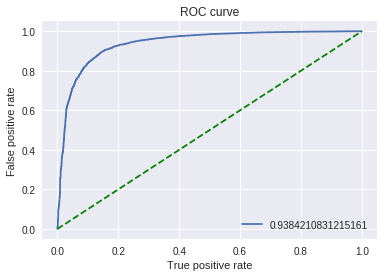

In [84]:
pred_test_w2vtf=lr_l2_w2vtf.predict_proba(tfidf_sent_vectors_test)
fpr,tpr,threshold=roc_curve(y_test,pred_test[:,1])
roc_auc_test=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_auc_test)
plt.plot([0, 1], [0, 1],'g--')
plt.legend()
plt.show()